In [1]:
#imports
import os
import glob as gb
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
import tempfile

#tensorflow imports
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
#import tfmot and numpy
!pip install tensorflow-model-optimization
import tensorflow_model_optimization as tfmot
import numpy as np


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#mount to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#copy dataset from drive
!cp -r ./drive/MyDrive/fer.zip ./

#import
import zipfile

with zipfile.ZipFile("./fer.zip", "r") as zip_ref:
    zip_ref.extractall("./")

#copy validation 
!cp -r "./test" "./validation" 

#paths to sets
train_dir = "./train"
test_dir = "./test"
val_dir = "./validation"

#remove Public images from testing dir
for root, subdirs, files in os.walk(test_dir):
    for file in files:
        if file.startswith("Public"):
            os.remove(os.path.join(root,file))



#remove Private images from validation dir
for root, subdirs, files in os.walk(val_dir):
    for file in files:
        if file.startswith("Private"):
            os.remove(os.path.join(root,file))

#set batch size and classes
batch = 64
classes = ["angry", "fear", "happy","neutral","sad","surprise"]

In [5]:
#set training data without data augmentation
train_datagen = ImageDataGenerator(rescale = 1./255)

#normalize validation data
val_datagen = ImageDataGenerator(rescale = 1./255)

#normalize test data
test_datagen = ImageDataGenerator(rescale = 1./255)



#get training set
training_set = train_datagen.flow_from_directory(train_dir,\
                                                 target_size = (48, 48),\
                                                 color_mode = "grayscale",\
                                                 class_mode = "categorical",\
                                                 shuffle = True,\
                                                 batch_size=batch,\
                                                 classes=classes)

#get val set
val_set = val_datagen.flow_from_directory(val_dir, target_size = (48, 48),\
                                            color_mode = "grayscale",\
                                            class_mode = "categorical",\
                                            classes = classes,\
                                            batch_size=batch,\
                                            shuffle = False)

#get test set
test_set = test_datagen.flow_from_directory(test_dir, target_size = (48, 48),\
                                            color_mode = "grayscale",\
                                            class_mode = "categorical",\
                                            classes = classes,\
                                            batch_size=batch,\
                                            shuffle = False)
print(training_set.class_indices)
print("angry", training_set.classes[training_set.classes == 0].shape[0])
print("fear", training_set.classes[training_set.classes == 1].shape[0])
print("happy", training_set.classes[training_set.classes == 2].shape[0])
print("neutral", training_set.classes[training_set.classes == 3].shape[0])
print("sad", training_set.classes[training_set.classes == 4].shape[0])
print("surprise", training_set.classes[training_set.classes == 5].shape[0])

Found 28273 images belonging to 6 classes.
Found 3533 images belonging to 6 classes.
Found 3534 images belonging to 6 classes.
{'angry': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprise': 5}
angry 3995
fear 4097
happy 7215
neutral 4965
sad 4830
surprise 3171


In [6]:
#load model for pruning
model_path = "./drive/MyDrive/model1_100epoch.h5"
model1 = load_model(model_path)

In [7]:
#get baseline accuracy
_, baseline_model_accuracy = model1.evaluate(
    test_set, verbose=0)
print("Baseline accuracy: ", baseline_model_accuracy)

Baseline accuracy:  0.6986417770385742


In [8]:
#todo optimize with pruning (and quantization) https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

batch = 64
epochs = 2

num_images = training_set.n
end_step = np.ceil(num_images / batch).astype(np.int32) * epochs // 2

# Define model for pruning.
pruning_params = {
      "pruning_schedule": tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.40,
                                                               final_sparsity=0.55,
                                                               begin_step=0,
                                                               end_step=end_step)
}


model_for_pruning = prune_low_magnitude(model1, **pruning_params)

model_for_pruning.compile(optimizer='adam',
                          loss=tf.keras.losses.CategoricalCrossentropy(),
                          metrics=['accuracy'])

#model_for_pruning.summary()


In [9]:
#fit 
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(training_set,
                  batch_size=batch, epochs=epochs, validation_data = val_set,
                  callbacks=callbacks)

Epoch 1/2
  6/442 [..............................] - ETA: 19s - loss: 0.4599 - accuracy: 0.8411

442/442 [==============================] - 44s 52ms/step - loss: 0.5805 - accuracy: 0.7898 - val_loss: 0.9526 - val_accuracy: 0.6669
Epoch 2/2
442/442 [==============================] - 24s 53ms/step - loss: 0.5349 - accuracy: 0.8053 - val_loss: 0.9922 - val_accuracy: 0.6878


In [10]:
#Compare to baseline
_, model_for_pruning_accuracy = model_for_pruning.evaluate(
   test_set, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy) 
print('Pruned test accuracy:', model_for_pruning_accuracy)

Baseline test accuracy: 0.6986417770385742
Pruned test accuracy: 0.6941143274307251


In [11]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

model_for_export.compile(optimizer='adam',
                          loss=tf.keras.losses.CategoricalCrossentropy(),
                          metrics=['accuracy'])

#include optimizer to avoid annoying warning messages even tho it is not needed
tf.keras.models.save_model(model_for_export, "./drive/MyDrive/fer2013_pruned.h5")

In [12]:
test_model = load_model("./drive/MyDrive/fer2013_pruned.h5")


test_model.evaluate(test_set)

56/56 [==============================] - 2s 29ms/step - loss: 0.9237 - accuracy: 0.6941


[0.9237264394760132, 0.6941143274307251]

In [13]:
# Function for plotting confusion matrix
def plot_cm(cm, classes, normalize):
    title = "Confusion Matrix"
    fmt = ""
    if normalize:
      title = "Confusion Matrix, normalized"
      fmt = ".2f"
      cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title(title)
    
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

56/56 [==============================] - 2s 28ms/step
[[306  36  22  58  59  10]
 [ 62 225  14  77  85  65]
 [ 14   7 783  35  22  18]
 [ 29  17  39 478  56   7]
 [ 65  39  30 136 315   9]
 [ 10  20  19  15   6 346]]
Accuracy:  0.6941143180531976
56/56 [==============================] - 2s 36ms/step - loss: 0.9237 - accuracy: 0.6941


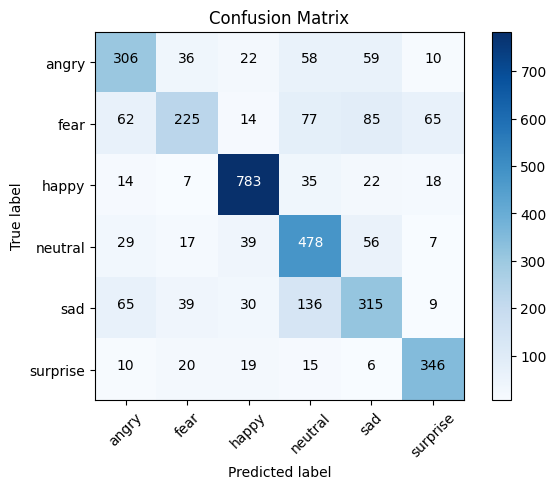

In [14]:
#get true labels

true_labels = test_set.classes

#make predictions
preds1 = test_model.predict(test_set)
predicted_labels = np.argmax(preds1, axis=1)

#get confusion matrix
cm1 = confusion_matrix(true_labels, predicted_labels)
print(cm1)
#get accuracy
print("Accuracy: ", np.trace(cm1) / np.sum(cm1))
model1.evaluate(test_set)

#plot
plt.figure()
plot_cm(cm1,classes,False)
plt.show()

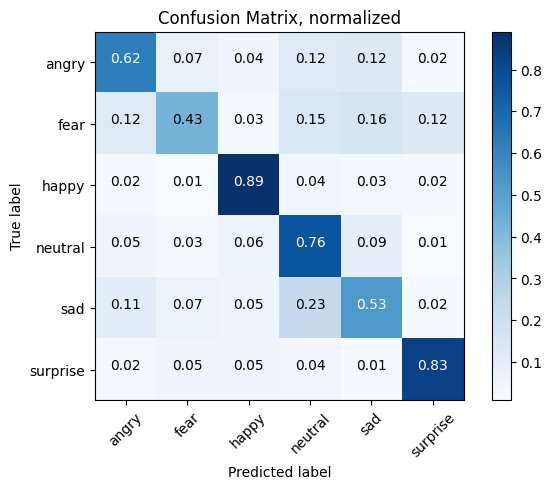

In [15]:
#plot
plt.figure()
plot_cm(cm1,classes,True)
plt.show()